This notebook performs response-weighted analysis on the activation outputs of a traditional MNIST model.

# Initialisations

In [4]:
# import argparse
from rwa import *

import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchvision import datasets, transforms
# from sklearn.neighbors import KernelDensity
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2

In [5]:
# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(10*10*64, 128)  
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x1 = self.conv1(x)
        x = F.relu(x1)
        x2 = self.conv2(x)
        x = F.relu(x2)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        
        return x1, x2

In [6]:
net = Net()
net.eval()
modelfilename = './model_data/mnist_model/mnist_cnn.pt'
net.load_state_dict(torch.load(modelfilename)) # load the model
print(net)
print(net.state_dict().keys())

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


# Weights Visualisation

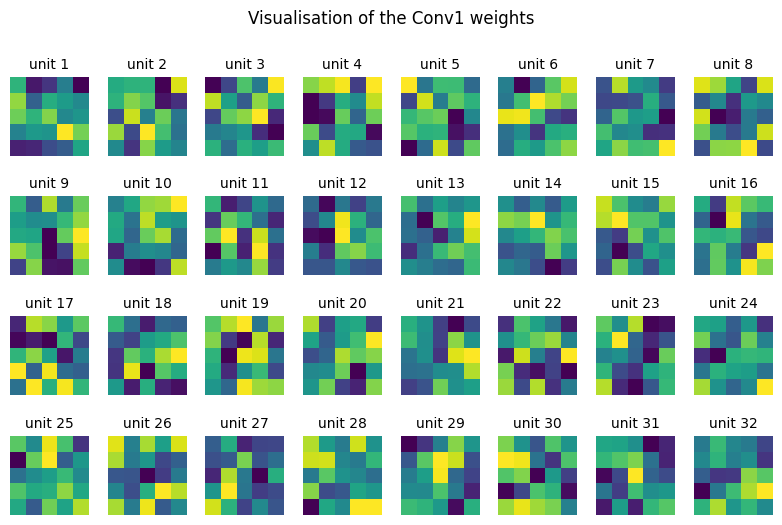

In [7]:
# conv1 weights (kernels) visualisation - 16 units
w1 = net.state_dict()['conv1.weight']
w1 = np.transpose(w1, (0, 2, 3, 1)) # transform to visualisation format in rgb state

# visualise the weights as RGB images
for i in range(w1.shape[0]): # loop through each unit
    plt.subplot(4, 8, i+1)
    plt.axis('off')
    to_show = (w1[i] - w1[i].min()) / (w1[i].max() - w1[i].min()) # normalise to [0, 1]
    plt.imshow(to_show)
    plt.title('unit ' + str(i+1), fontsize=10)
plt.suptitle('Visualisation of the Conv1 weights')
plt.tight_layout()
plt.gcf().set_size_inches(8, 5.5)
plt.show()

# Lab Recording Room

In [8]:
# experiment settings
NBatches = 50
BSize = 1000
zeroMean = True
layer = 'conv1'

In [9]:
act_conv1, noise1 = ActRecorder_mnist(layer, net, NBatches=NBatches, BSize=BSize, zeroMean=zeroMean)
print(noise1.min(), noise1.max(), noise1.mean())

100%|██████████| 32/32 [00:00<00:00, 384.74it/s]


Shape of activation response list: torch.Size([32, 50000])
Shape of noise list: torch.Size([50000, 28, 28, 1])
tensor(-127.5000) tensor(127.5000) tensor(-0.0132)


In [10]:
# save the activation and noise data
torch.save(act_conv1, './rwa_data/mnist/mnist_rand_0mean/act1.pt')
torch.save(noise1, './rwa_data/mnist/mnist_rand_0mean/noise1.pt')

# Conv1 - Zero Mean [-127.5, 127,5]

In [62]:
# load existing data if already recorded
act_conv1 = torch.load('./rwa_data/mnist/mnist_rand_0mean/act1.pt')
noise1 = torch.load('./rwa_data/mnist/mnist_rand_0mean/noise1.pt')
rf1 = torch.load('./rwa_data/mnist/mnist_rand_0mean/rf1.pt')

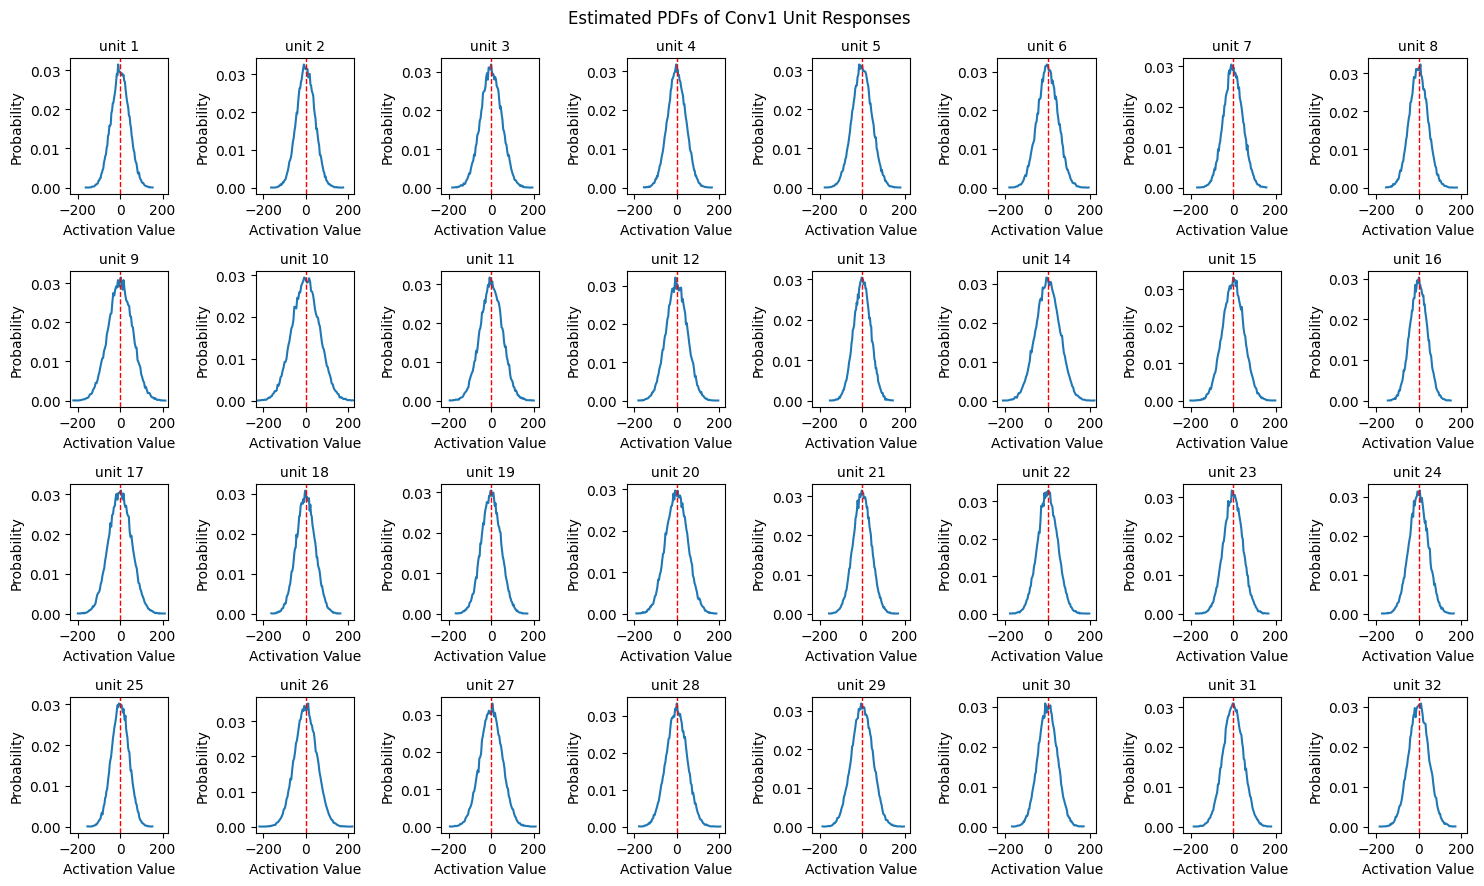

In [11]:
# PDFs of conv1 responses
# gaussian shape is a result of convolution
for i in range(act_conv1.shape[0]):
    plt.subplot(4, 8, i+1)
    plt.xlim(act_conv1.min(), act_conv1.max())
    
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv1[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv1[i].mean(), color='red', linestyle='dashed', linewidth=1)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 9)

plt.suptitle('Estimated PDFs of Conv1 Unit Responses')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 9)
plt.show()

RWA

In [12]:
# RWA
rf1 = RWA(layer, net, act_conv1, noise1, inputX=28, inputY=28, NBatches=NBatches, BSize=BSize)
# adjust dimensions of rf1 from 3 channels to 1 channel for mnist
rf1 = rf1[:,:,:,0]

100%|██████████| 1600000/1600000 [01:18<00:00, 20257.29it/s]

Shape of receptive field list: torch.Size([32, 28, 28, 3])


In [13]:
# Save the RWA data
torch.save(rf1, './rwa_data/mnist/mnist_rand_0mean/rf1.pt')

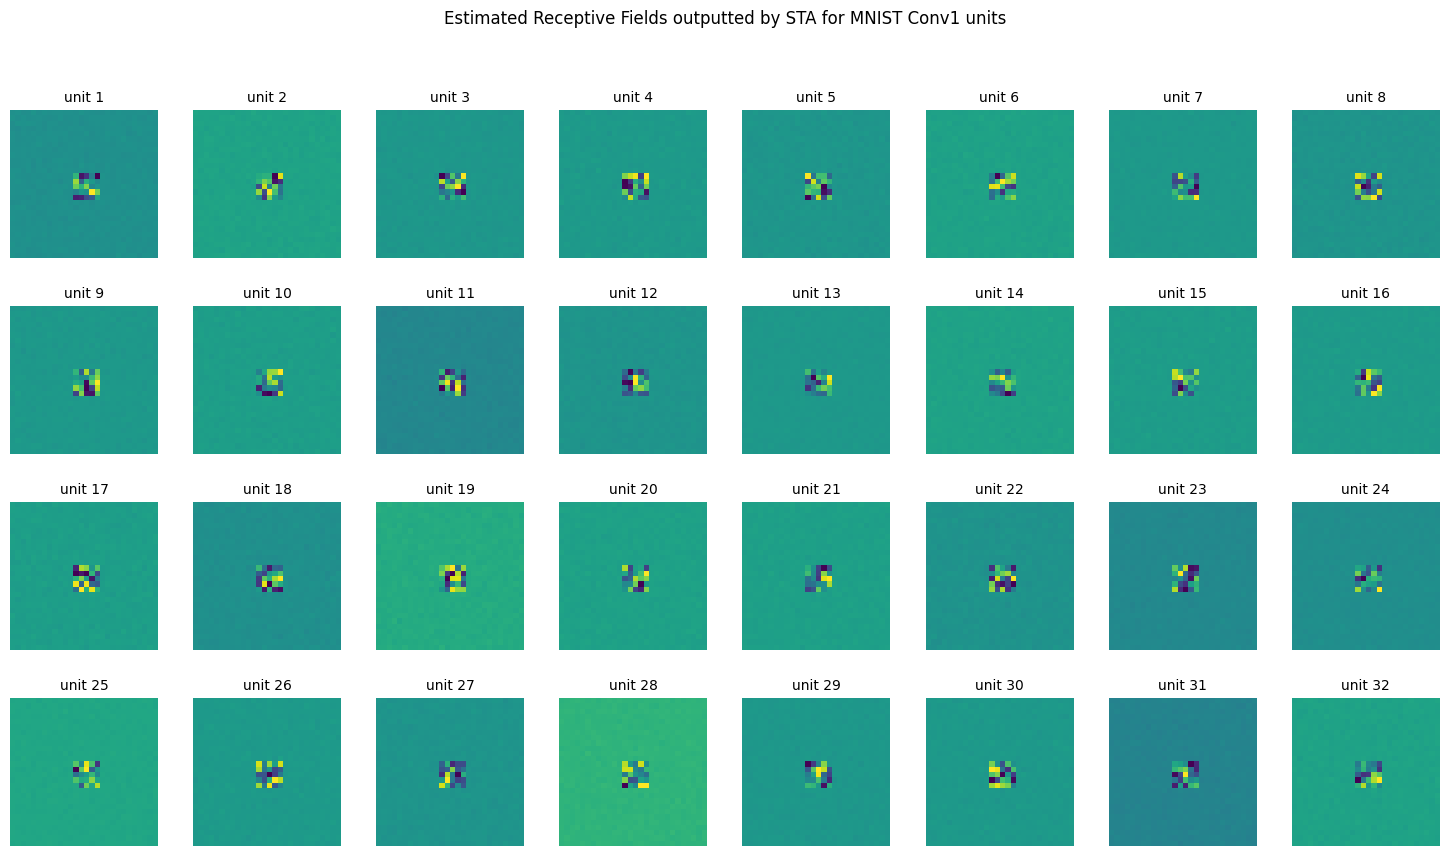

In [15]:
# Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf1[i]
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0:
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Estimated Receptive Fields outputted by STA for MNIST Conv1 units')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 9)
plt.show()

# Conv1 - Positive Only [0, 255]

In [66]:
# load existing data if already recorded
act_conv1 = torch.load('./rwa_data/mnist/mnist_rand/act1.pt')
noise1 = torch.load('./rwa_data/mnist/mnist_rand/noise1.pt')
rf1 = torch.load('./rwa_data/mnist/mnist_rand/rf1.pt')

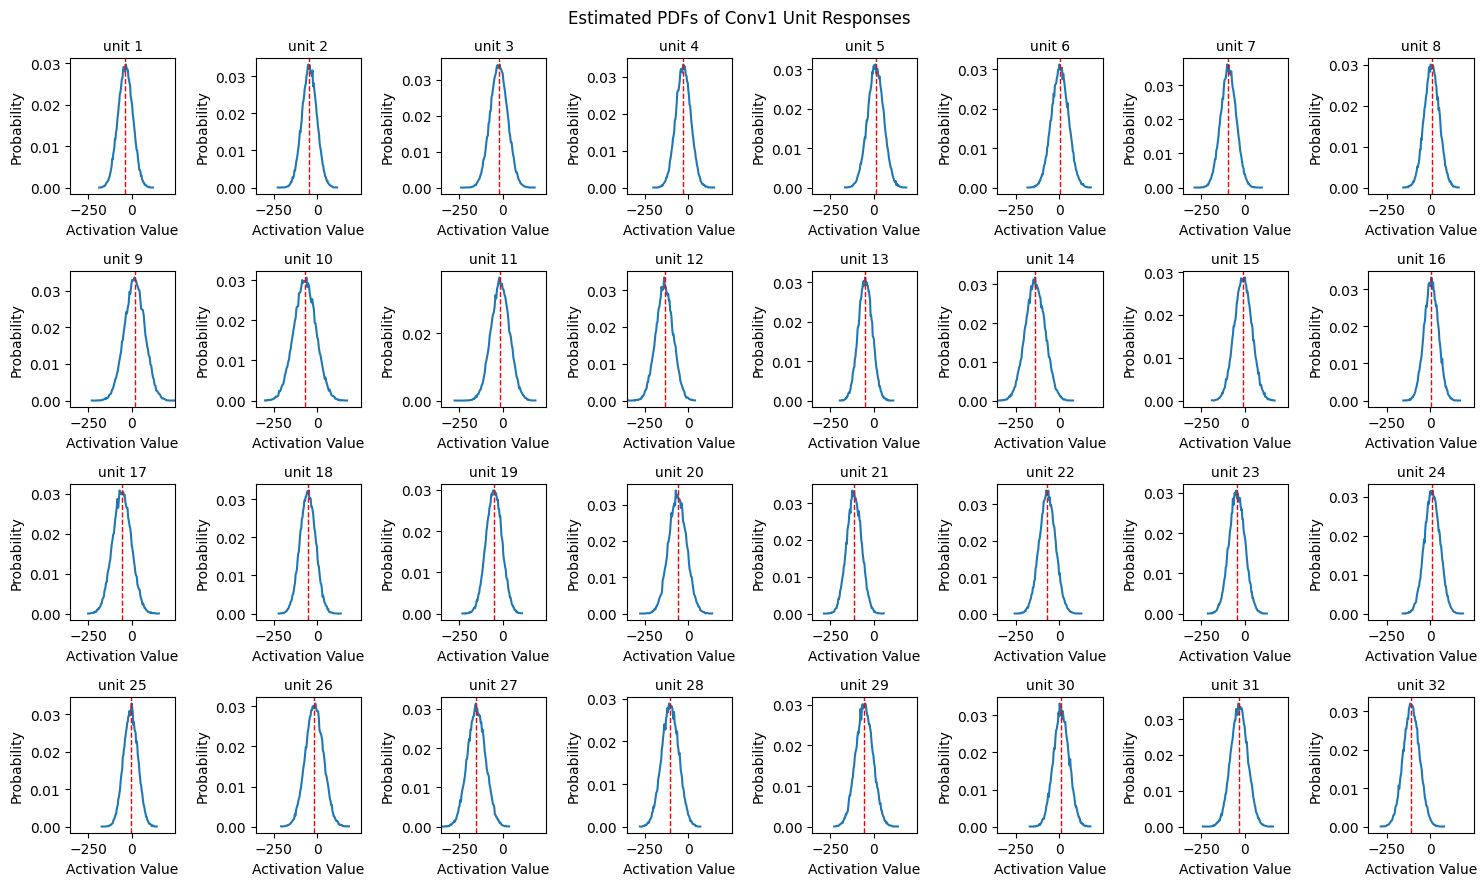

In [67]:
# PDFs of conv1 responses
for i in range(act_conv1.shape[0]):
    plt.subplot(4, 8, i+1)
    plt.xlim(act_conv1.min(), act_conv1.max())
    
    if act_conv1[i][act_conv1[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv1[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv1[i].mean(), color='red', linestyle='dashed', linewidth=1)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 9)

plt.suptitle('Estimated PDFs of Conv1 Unit Responses')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 9)
plt.show()

RWA

In [17]:
# RWA
rf1 = RWA(layer, net, act_conv1, noise1, inputX=28, inputY=28, NBatches=NBatches, BSize=BSize)
# adjust dimensions of rf1 from 3 channels to 1 channel for mnist
rf1 = rf1[:,:,:,0]

100%|██████████| 1600000/1600000 [01:23<00:00, 19243.20it/s]

Shape of receptive field list: torch.Size([32, 28, 28, 3])


In [18]:
# Save the RWA data
torch.save(rf1, './rwa_data/mnist/mnist_rand/rf1.pt')

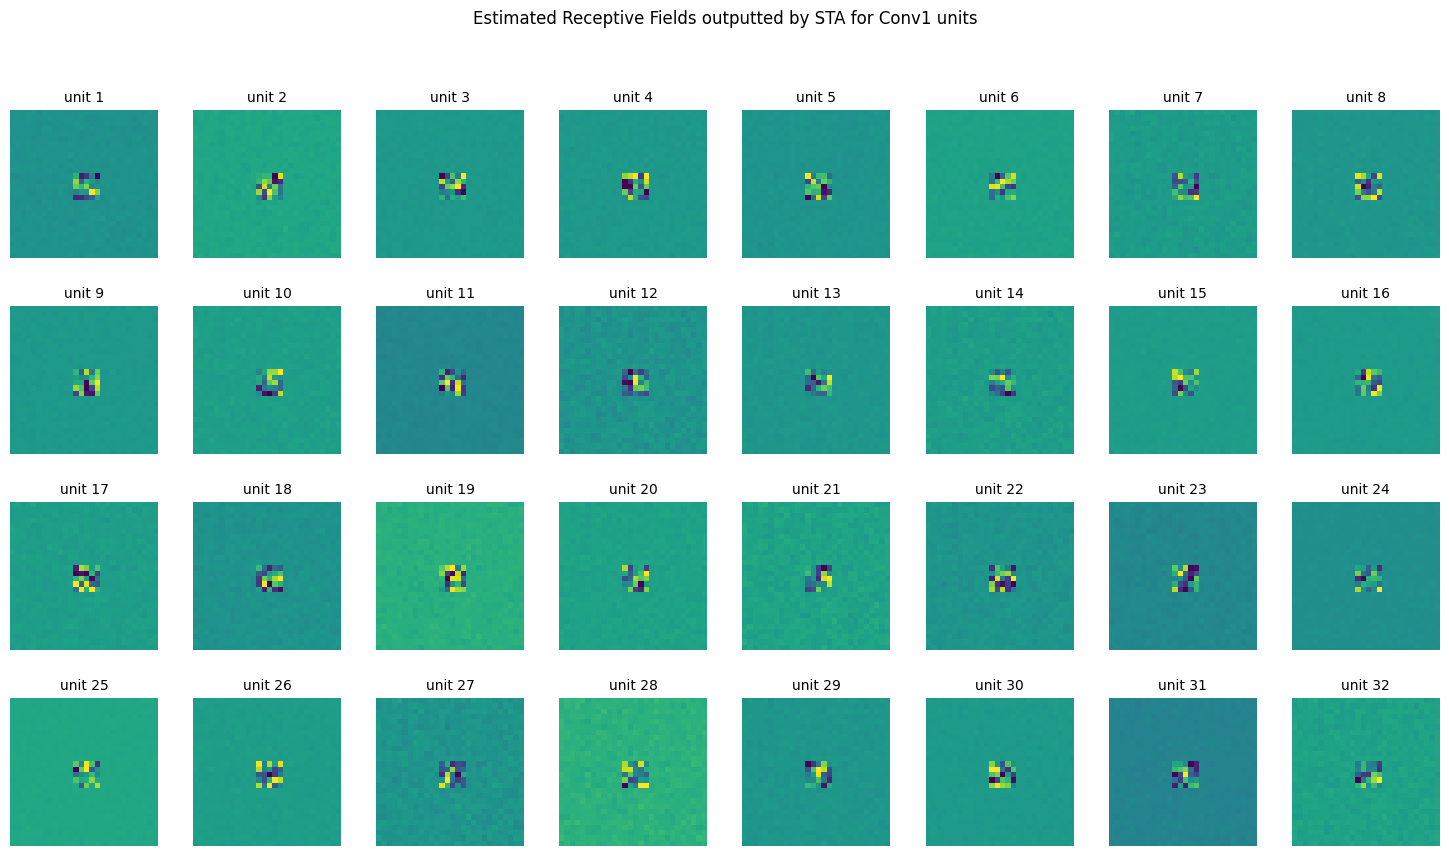

In [68]:
# Visualise the RWA output as image plots
for i in range(rf1.shape[0]):
    plt.subplot(4, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf1[i]
    if act_conv1[i][act_conv1[i] > 0].shape[0] != 0:
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)

# title for the entire plot
plt.suptitle('Estimated Receptive Fields outputted by STA for Conv1 units')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 9)
plt.show()

# Conv2 - Zero Mean [-127.5, 127,5]

In [59]:
# load existing data if already recorded
act_conv2 = torch.load('./rwa_data/mnist/mnist_rand_0mean/act2.pt')
noise2 = torch.load('./rwa_data/mnist/mnist_rand_0mean/noise2.pt')
rf2 = torch.load('./rwa_data/mnist/mnist_rand_0mean/rf2.pt')

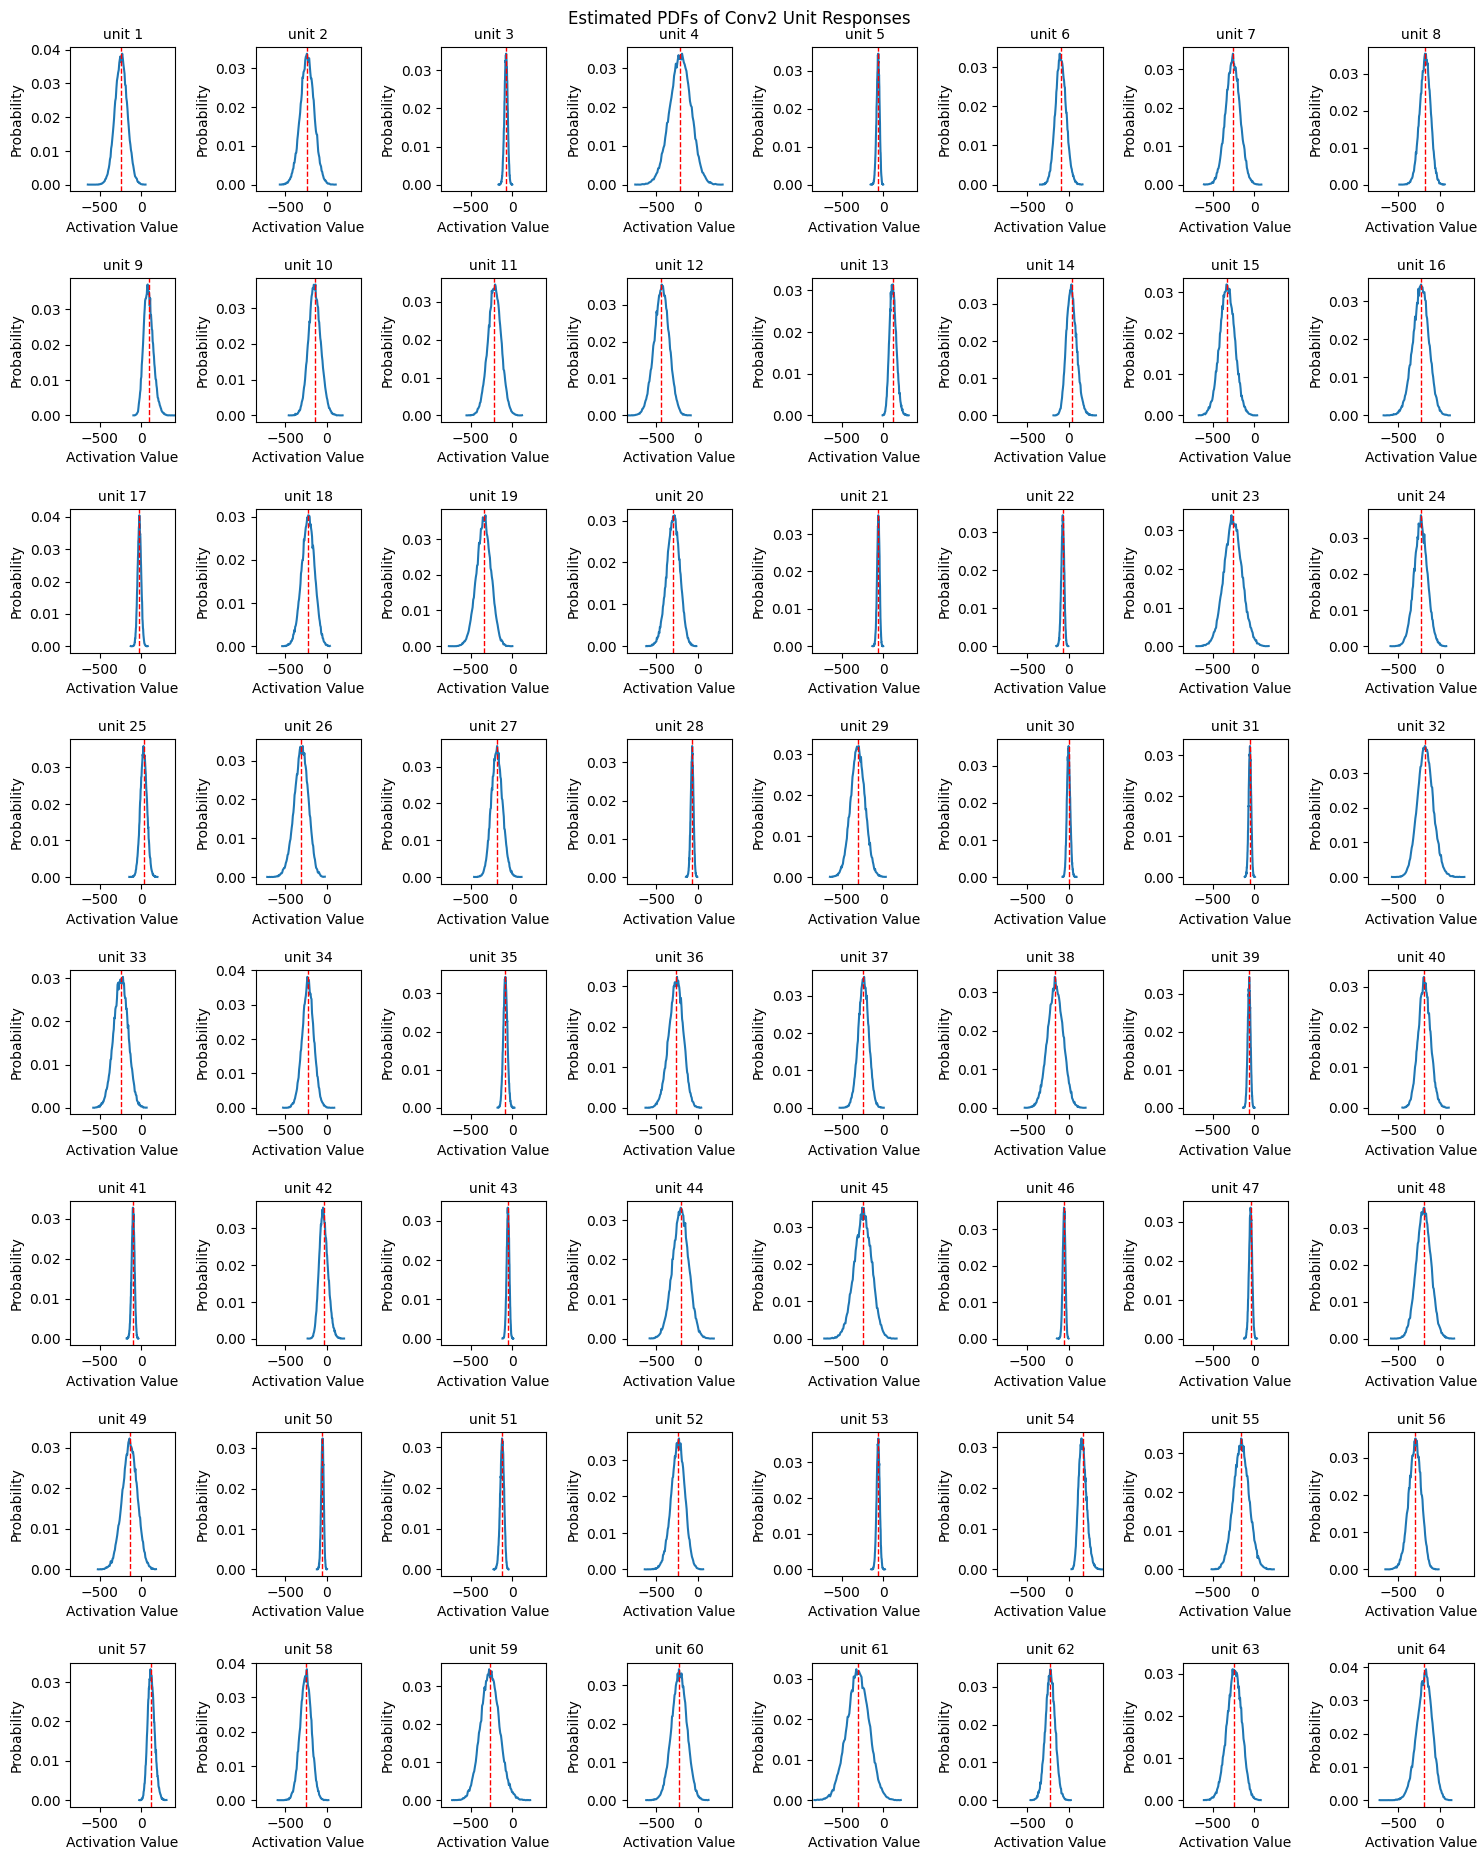

In [60]:
# PDFs of conv2 responses
for i in range(act_conv2.shape[0]):
    plt.subplot(8, 8, i+1)
    plt.xlim(act_conv2.min(), act_conv2.max())
    
    if act_conv2[i][act_conv2[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv2[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv2[i].mean(), color='red', linestyle='dashed', linewidth=1)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 17)

plt.suptitle('Estimated PDFs of Conv2 Unit Responses')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 19)
plt.show()

RWA

In [28]:
# RWA
rf2 = RWA(layer, net, act_conv2, noise2, inputX=28, inputY=28, NBatches=NBatches, BSize=BSize)
# adjust dimensions of rf1 from 3 channels to 1 channel for mnist
rf2 = rf2[:,:,:,0]

100%|██████████| 3200000/3200000 [02:47<00:00, 19092.83it/s]

Shape of receptive field list: torch.Size([64, 28, 28, 3])


In [33]:
# Save the RWA data
torch.save(rf2, './rwa_data/mnist/mnist_rand_0mean/rf2.pt')

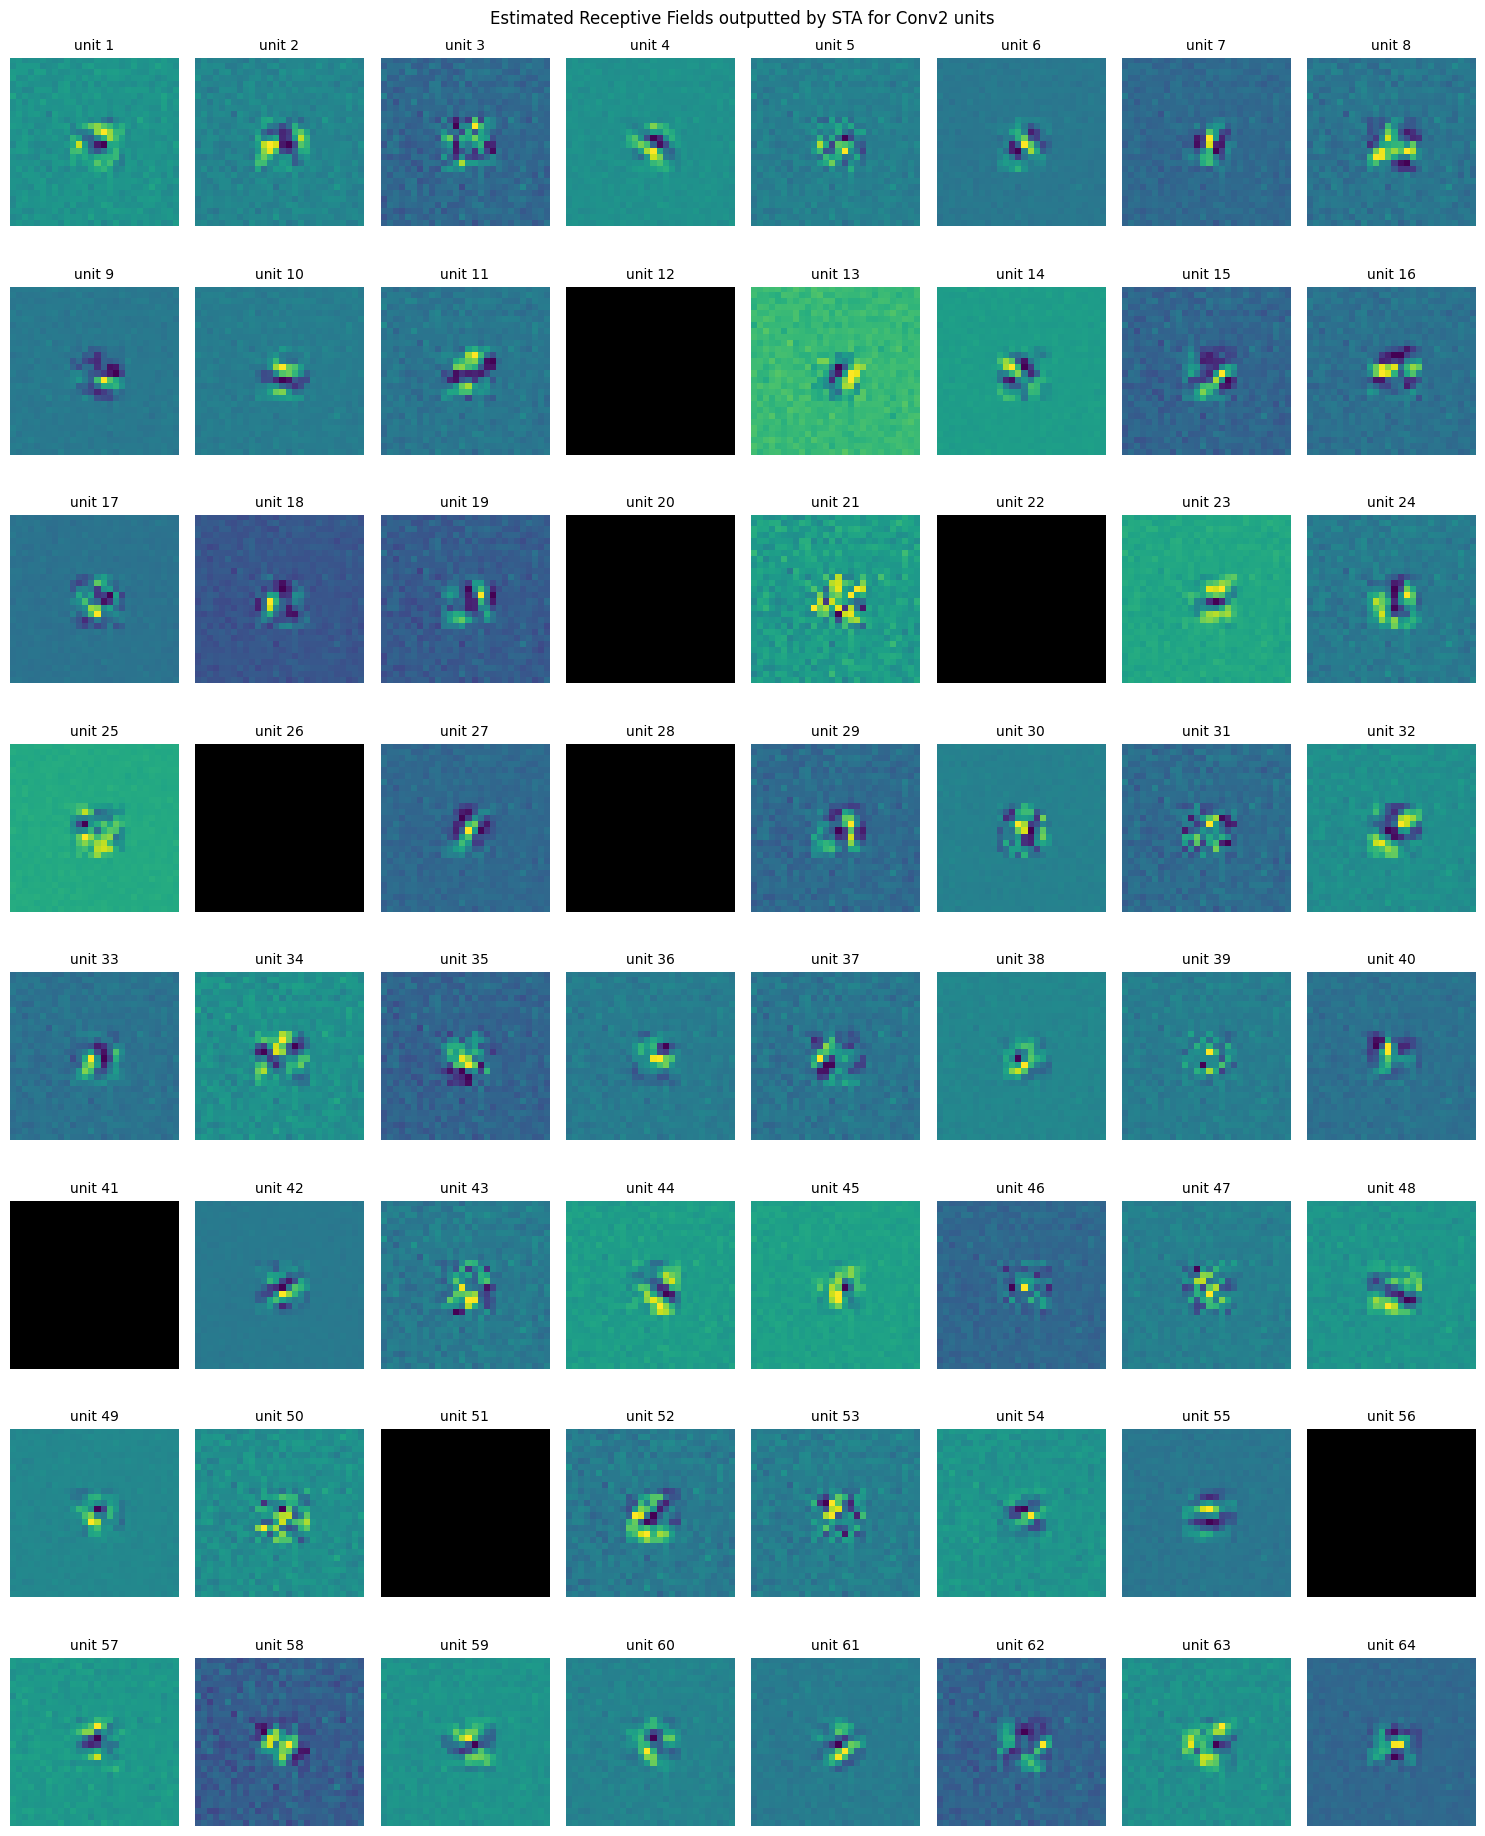

In [61]:
# Visualise the RWA output as image plots
for i in range(rf2.shape[0]):
    plt.subplot(8, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf2[i]
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0:
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(13, 17)

# title for the entire plot
plt.suptitle('Estimated Receptive Fields outputted by STA for Conv2 units')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 19)
plt.show()

# Conv2 - Positive Only [0, 255]

In [53]:
# load existing data if already recorded
act_conv2 = torch.load('./rwa_data/mnist/mnist_rand/act2.pt')
noise2 = torch.load('./rwa_data/mnist/mnist_rand/noise2.pt')
rf2 = torch.load('./rwa_data/mnist/mnist_rand/rf2.pt')

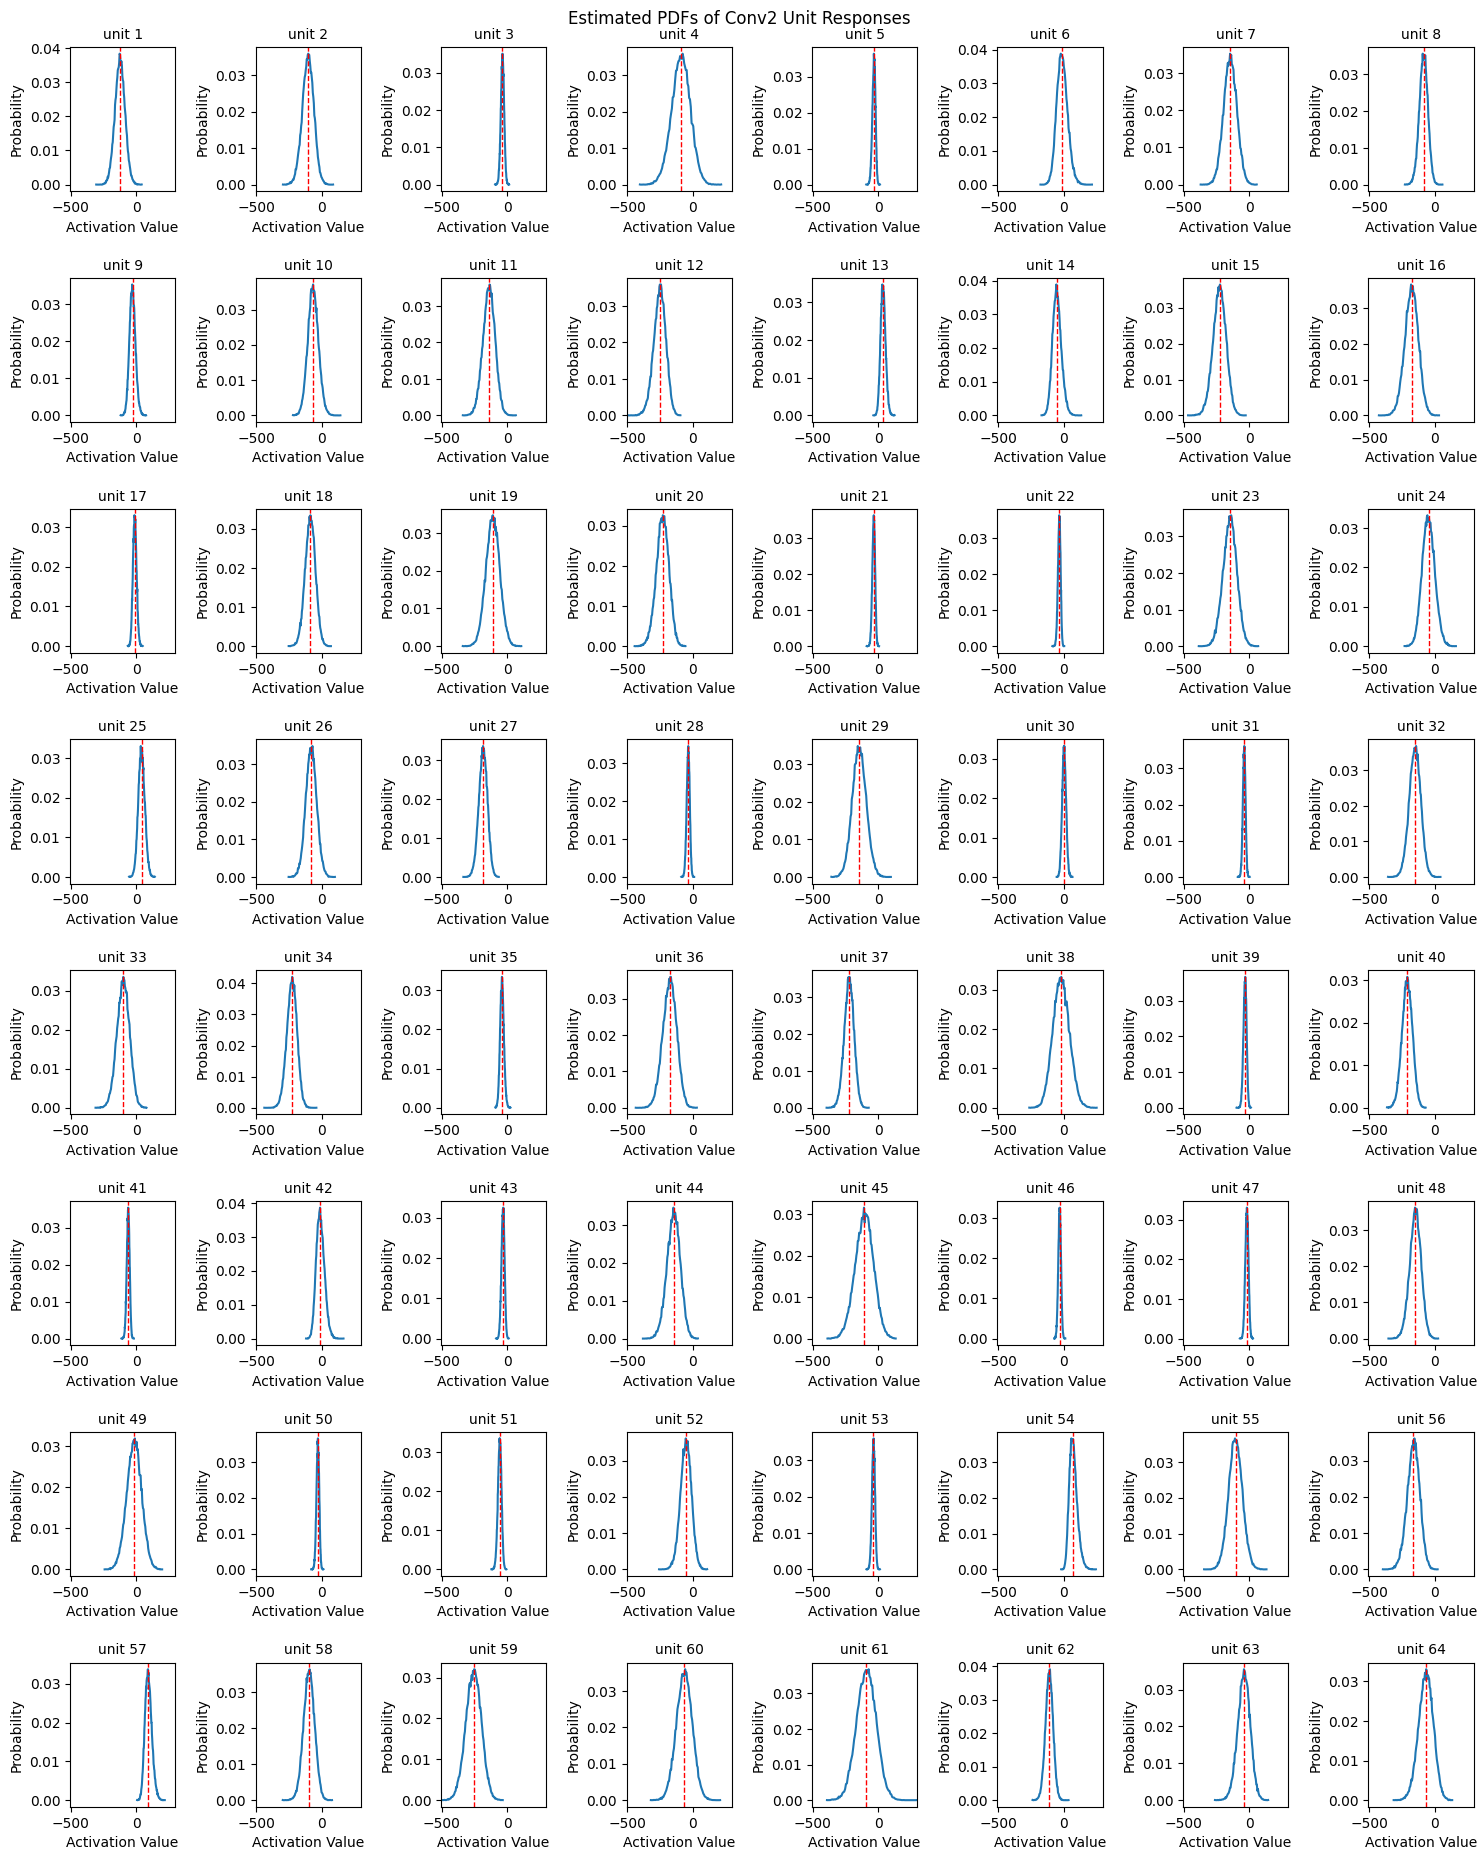

In [56]:
# PDFs of conv2 responses
for i in range(act_conv2.shape[0]):
    plt.subplot(8, 8, i+1)
    plt.xlim(act_conv2.min(), act_conv2.max())
    
    if act_conv2[i][act_conv2[i] != 0].shape[0] != 0: # if unit is not dead
        counts, bin_edges = np.histogram(act_conv2[i], bins=100)
        pdf = counts / sum(counts) # normalise the counts to get the PDF
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        plt.plot(bin_centers, pdf)
        plt.xlabel('Activation Value')
        plt.ylabel('Probability')
        plt.axvline(act_conv2[i].mean(), color='red', linestyle='dashed', linewidth=1)
    else:
        # plot shows text saying 'inactive'
        plt.text(0.5, 0.5, 'inactive', horizontalalignment='center', verticalalignment='center')
        plt.title('unit ' + str(i+1), fontsize=10)
        plt.axis('off')
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(14, 17)

plt.suptitle('Estimated PDFs of Conv2 Unit Responses')
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 19)
plt.show()

RWA

In [45]:
# RWA
rf2 = RWA(layer, net, act_conv2, noise2, inputX=28, inputY=28, NBatches=NBatches, BSize=BSize)
# adjust dimensions of rf1 from 3 channels to 1 channel for mnist
rf2 = rf2[:,:,:,0]

100%|██████████| 3200000/3200000 [01:52<00:00, 28428.07it/s]

Shape of receptive field list: torch.Size([64, 28, 28, 3])


In [46]:
# Save the RWA data
torch.save(rf2, './rwa_data/mnist/mnist_rand/rf2.pt')

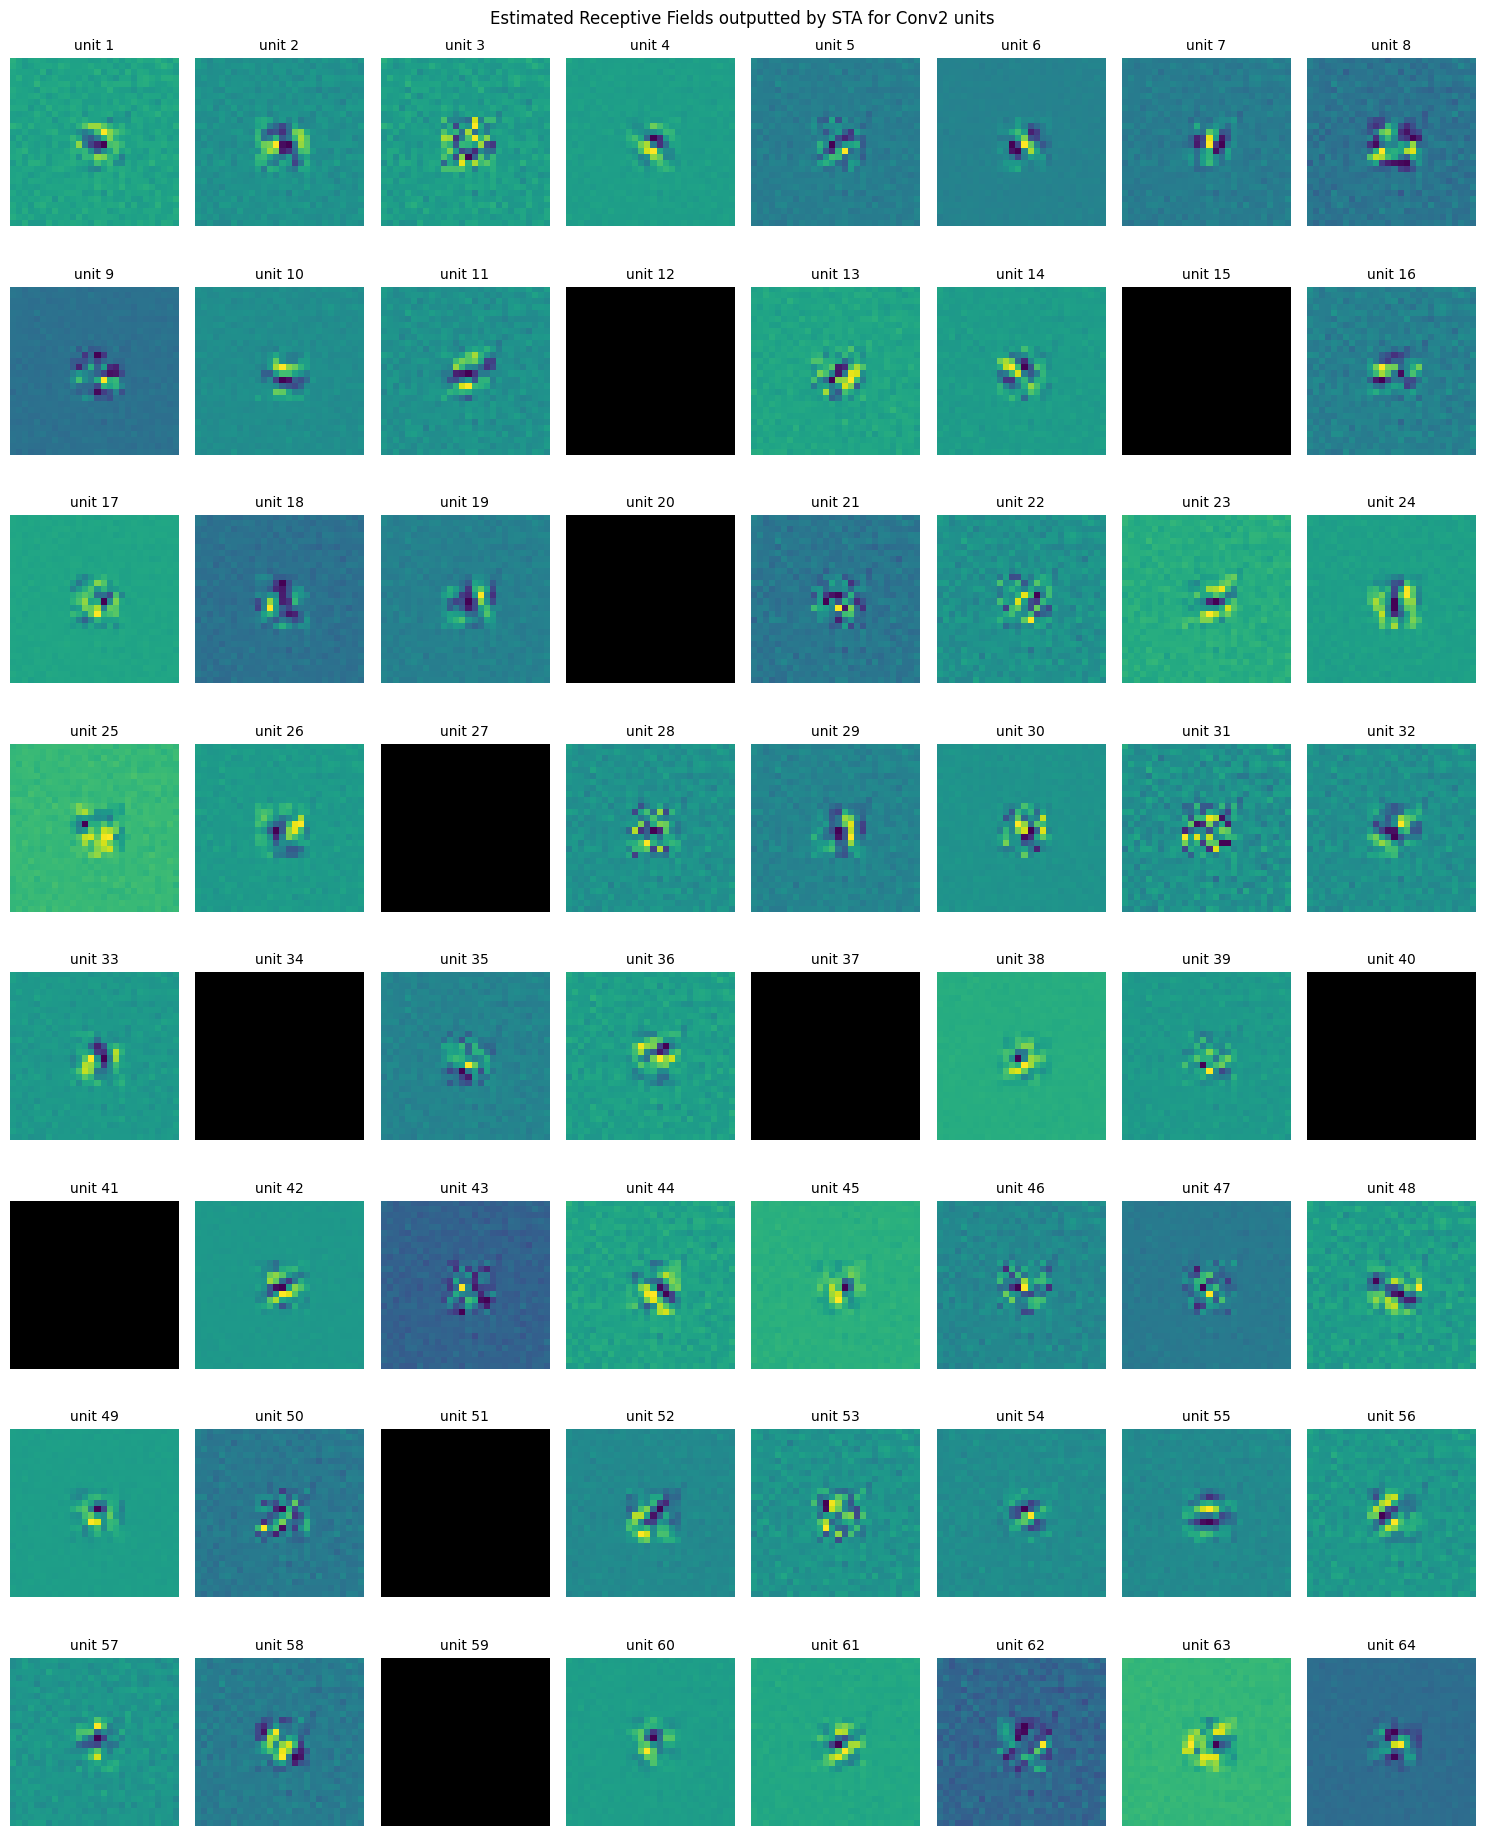

In [57]:
# Visualise the RWA output as image plots
for i in range(rf2.shape[0]):
    plt.subplot(8, 8, i+1) # nrows, ncols, index
    plt.axis('off')
    to_show = rf2[i]
    if act_conv2[i][act_conv2[i] > 0].shape[0] != 0:
        to_show = (to_show - to_show.min()) / (to_show.max() - to_show.min()) # normalise to [0, 1]
        plt.imshow(to_show)
    else:
        # show a black image
        plt.imshow(np.zeros((64, 64, 3)))
    plt.title('unit ' + str(i+1), fontsize=10)
    plt.gcf().set_size_inches(13, 17)

# title for the entire plot
plt.suptitle('Estimated Receptive Fields outputted by STA for Conv2 units')
# increase the spacing between subplots
plt.tight_layout()
# change figure size
plt.gcf().set_size_inches(15, 19)
plt.show()